In [11]:
%matplotlib inline

# Práctica 2. Detección de objetos con Faster-RCNN.

## Objetivo 

El propósito de este laboratorio es que el alumno se familiarice con una red neuronal convolucional de proposición de regiones (RCNN) para la detección automática de clases de objetos, en la que sobre una imagen se localizan espacialmente una serie de objetos, y se clasifican dichos objetos de acuerdo a unas clases predefinidas.

En concreto, se trabajará sobre la red Faster-RCNN, la primera red que aúna la estrategia de proposición de regiones automática (es decir, a partir de la imagen de entrada se proponen regiones susceptibles de contener objetos) con la clasificación de los mismos. En nuestro caso, esta red se aplicará a algunas de las clases de la base de datos PASCAL VOC para detección de objetos. 

Este tutorial es una adaptación del tutorial disponible en https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html. 

## Referencias

- [1] Faster-RCNN. https://arxiv.org/abs/1706.05587
- [2] PASCAL VOC 2012 dataset. http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html
- [3] https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection
- [4] https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/
- [5] Fast-RCNN y ROIPooling: https://arxiv.org/abs/1504.08083
- [6] https://en.wikipedia.org/wiki/File:RoI_pooling_animated.gif
- [7] FPN: https://arxiv.org/abs/1612.03144

## Antes de empezar

Antes de empezar, asegúrese de que todos los archivos que se proporcionan con la práctica se encuentran en el mismo directorio de este Notebook.

## Parte 1. Fundamento teórico.

### Detección de objetos

En el caso de la detección de objetos, un objeto se define de acuerdo a una _bounding box_ (una caja que engloba al objeto completo). La *bounding box* se define de acuerdo a su centro, anchura y altura (normalizados al tamaño de la imagen). Para una imagen de ejemplo y el objeto "gato":
<img src="images/notebook/cs.PNG">
Cada uno de estos objetos también llevará asociada una etiqueta de acuerdo a las categorías predeterminadas. Si por ejemplo en nuestro caso, la categoría "perro" se define como la clase 1 y la categoría "gato" como la clase 2, la etiqueta de este objeto será 2.

### Faster-RCNN

Aunque se recomienda echar un vistazo al artículo sobre Faster-RCNN [1], en esta sección se van a explicar los conceptos más importantes de la red que son necesarios para el desarrollo de la práctica.

Faster-RCNN es un _framework_ que adapta cualquier red convolucional dedicada a la clasificación (dada una imagen, encontrar una categoría que describa el contenido total de la imagen) a la detección de objetos (en una imagen pueden coexistir objetos distintos). Para ello, a partir de un _backbone_ inicial (las capas destinadas a la extracción de características) de cualquier red de clasificación, propone dos bloques: la red de proposición de regiones y el *RoI pooling* para clasificación. 

<img src="images/notebook/faster.JPEG">

Por tanto, la arquitectura de Faster-RCNN parte de un mapa de características proveniente de las capas convolucionales, típicamente con _stride_ 16: es decir, si el tamaño de la imagen de entrada es H x W, los mapas de características sobre los que trabaja la red de proposición de regiones son de tamaño H/16 x W/16. A partir de este mapa de características se incluyen dos módulos: una sub-red para proposición de regiones que se ejecuta en primer lugar; y un segundo módulo convolucional que a partir de las características y las regiones propuestas clasifica cada una de ellas de acuerdos a unas clases predeterminadas, haciendo uso de la estrategia de *RoI pooling*.

#### Red de proposición de regiones

El objetivo de este bloque es extraer las regiones de la imagen susceptibles de contener un objeto, es decir, proponer una serie de _bounding boxes_ candidatas. Para ello, en cada localización espacial de estos mapas de características se consideran _k_ _anchors_ invariantes a la traslación (regiones de tamaño y relación de aspecto fijas). Típicamente, _k_=9 (se consideran 3 tamaños distintos: 128, 256 y 512 píxeles; y las relaciones de aspecto 1:1, 1:2 y 2:1).  

He aquí un ejemplo visual de la localización espacial del conjunto de _anchors_ invariantes a la traslación sobre una imagen de entrada.

<img src="images/notebook/anchor_centers.png">

Y el aspecto visual de los _anchors_ sobre la misma, en la localización de la persona, en el centro de la figura, así como sobre toda la imagen (el total de _anchors_ para la imagen).

<img src="images/notebook/anchors-progress.png">

Ahora bien, del gran número de _anchors_ con los que se cuenta ($k \cdot H/16 \cdot W/16$), sólo algunos coinciden con la posición y tamaño real de los objetos en la imagen. Para distinguir estos _anchors_ del total de los mismos se tiene una función de pérdida $L_{objectness}$ que se ocupa de clasificar los _anchors_ que tienen una IoU - _Intersection over Union_ - elevada con algún objeto del _ground truth_ como _anchors_ buenos. Para más detalles, véase [1].

Finalmente, los _anchors_ no pueden representar nuestra predicción (son poco precisos a la hora de localizar objetos). Sin embargo, los _anchors_ representan el punto de partida aproximado para ajustar la predicción al objeto que se quiere detectar. Se puede considerar cada _bounding box_ predicha como una ligera desviación frente al _anchor_. 

Así, Faster-RCNN considera la _bounding box_ predicha como la diferencia entre la _bounding box_ del objeto real y la del _anchor_ seleccionado para dicho objeto. La función de pérdida $L_{reg}$ cuantifica esta pérdida de acuerdo a los parámetros de la _bounding box_ que se han definido anteriormente: centro, anchura y altura, como se muestra en la siguiente imagen. Para más detalles, véase [1].

<img src="images/notebook/reg.PNG">

Por tanto, la función de pérdida $L_{objectness}$ se ocupa de encontrar el mejor _anchor_ para un objeto dado, mientras que la función $L_{reg}$ adapta ese _anchor_ al tamaño original del objeto.

#### _RoI pooling_ y clasificación

Hasta ahora, se han definido los objetos de manera agnóstica: no se ha prestado atención a su categoría. Una vez que la red de proposición de regiones es capaz de ofrecer una serie de _bounding boxes_ candidatas, es momento de obtener su categoría. Ahora bien, las regiones que propone la red pueden ser de tamaños muy diferentes, pero para ejecutar una red neuronal para clasificación el tamaño de los mapas de características para todas las imágenes debe ser el mismo. Para transformar la información que proporcionan los mapas de características que propone la red de proposición de regiones -de distinto tamaño- a un tamaño fijo (por ejemplo, 7x7), se utiliza el _RoI pooling_. 

La capa de _RoI pooling_ transforma las características dentro de cualquier región válida de la imagen de tamaño $H_{bb}$ x $W_{bb}$ en un _grid_ de tamaño fijo $H_{fix}$ x $W_{fix}$. Para ello, se divide la región de tamaño $H_{bb}$ x $W_{bb}$ en $H_{fix}$ x $W_{fix}$ celdas, cada una de ellas con tamaño $H_{bb}/H_{fix}$ x $W_{bb}/W_{fix}$. Tras esto, se aplica un _max pooling_ en cada celda para obtener el valor máximo de la misma, que es el valor que aparecerá en la posición de dicha celda en el _grid_ de salida. La siguiente animación muestra un ejemplo de _RoI pooling_ sobre un mapa de características, con un tamaño de *bounding box* de 5x7,  para un tamaño de salida de 2x2.

<img src="images/notebook/RoI_pooling_animated.gif">

Una vez se tienen las regiones con un tamaño fijo, la red clasifica las mismas de acuerdo a la categoría de objeto. La función de pérdida multiclase $L_{cls}$ se ocupa de esto. Asimismo, la red refina las _bounding boxes_ para cada clase de objetos (la función de pérdida $L_{reg2}$ se ocupa de esto). Mientras que en el primer caso la regresión era agnóstica (independiente de la clase del objeto), en este caso la regresión tiene en cuenta la categoría de cada objeto.

A continuación se muestra un posible resultado de la detección de objetos sobre una imagen de entrada: *bounding box* + predicción de la clase de objeto (con su verosimilitud).

<img src="images/notebook/result.PNG">


### FPN 

Para las redes de detección de objetos, la detección a diferentes escalas es un reto, en particular para objetos pequeños. La estrategia tradicional para ello es la construcción de una pirámide para la imagen a diferentes escalas (véase la figura de abajo [7]), y la aplicación del mismo procedimiento de detección para las diferentes escalas. Sin embargo, en el caso de redes neuronales el procesamiento de diferentes versiones de la misma imagen exige memoria y tiempo. Sin embargo, este procesamiento multiescala se puede aplicar a las características de alto nivel de alguna capa de la red (ya procesadas), lo que es más eficiente (además su dimensión espacial es menor).

<img src="images/notebook/pyramid.jpeg">

Hay que tener en cuenta que los mapas de características cercanos a la entrada no son útiles para la detección de objetos, ya que están compuesto de estructuras a bajo nivel (bordes) de la imagen. Por ello, frecuentemente, de manera previa a la proposición de regiones (RPN) se aplica una *Feature Pyramid Network* (FPN), un extractor de características que genera mapas de características de diferente tamaño (multiescala) con información diferente para cada escala, como se muestra en la figura posterior [7].

<img src="images/notebook/fpn.png">

Sobre cada uno de estos mapas de características, la RPN propone los *anchors*. En concreto, en función de la resolución espacial de cada mapa de características la RPN utiliza distintos *anchors* invariantes a la traslación: la RPN propone los *anchors* invariantes a la traslación de tamaño más pequeño sobre el mapa de características de mayor resolución y los *anchors* invariantes a la traslación más grandes sobre las localizaciones de los mapas de menor resolución. Esto tiene sentido desde el punto de vista lógico: sobre los mapas con mayor información de bajo nivel se colocan los *anchors* pequeños para buscar objetos de pequeño tamaño, y sobre los mapas con información a alto nivel se colocan los *anchors* de mayor tamaño, que buscan objetos que suponen un gran porcentaje del área de la imagen.

Para más información, véase [7].

### Medidas de evaluación

El rendimiento del sistema en detección se analiza en términos de la medida F1. Sin embargo, para definir esta medida hay que definir antes la precisión y el *recall*. Cada una de estas medidas se definen a continuación.

La __precisión__, para el caso de detección de objetos, representa el porcentaje de objetos correctamente detectados del total de objetos detectados (correctos e incorrectos). Se calcula como:

\begin{equation}
P=\frac{TP}{TP+FP},
\end{equation}

donde $TP$ hace referencia al número de *true positives* (objetos correctamente detectados) y $FP$ al número de *false positives* (objetos incorrectamente detectados).

El __*recall*__, por su parte, representa el porcentaje de objetos correctamente detectados del total de objetos presentes en la imágenes. Se calcula como:

\begin{equation}
R=\frac{TP}{TP+FN},
\end{equation}

donde $FN$ representa el número de *false negatives* (objetos presentes en las imágenes pero no detectados).

Ahora bien, la red proporciona una serie de *bounding boxes* sobre la imagen que pueden coincidir en mayor o menor medida con el *ground truth*. Hay que establecer un __criterio para considerar una predicción como correcta__. Este se suele establecer en la calidad de segmentación, mediante la medida *Intersection over Union*, __IoU__, también denominada *Jaccard Index* (JI). La medida $IoU$ mide la similitud entre dos regiones $A$ y $B$ como:

\begin{equation}
IoU=\frac{A \cap B}{A \cup B}
\end{equation}

siendo $\cap$ la intersección entre las regiones (area común) y $\cup$ la unión o área total que cubren entre ambas. Se considera un umbral mínimo de $IoU_{th}=0.5$ o $IoU_{th}=0.7$ para considerar una detección como correcta. A continuación se puede ver un ejemplo de la medida $IoU$ sobre *bounding boxes*, como se utilizará en nuestra arquitectura de detección de objetos.

<img src="images/notebook/iou.png" width="500 pix">


De igual modo, la medida $IoU$ se puede utilizar para establecer la calidad en la segmentación de instancias de objetos.

Finalmente, una vez que se han descrito estas medidas se pueden definir la medida F1. El F1-*score* considera tanto la precisión como el *recall* para obtener una media armónica ponderada entre los mismos tal que: 

\begin{equation}
F1=2\cdot \frac{P\cdot R}{P+R},
\end{equation}

De este modo, esta medida resume en una sola cifra el rendimiento de nuestro detector de objetos para un __punto de operación__ dado. La red proporciona una serie de *bounding boxes* con un __*score*__ asociado, que nos indica cómo de probable es que en dicha región exista un objeto de cierta clase. Ahora bien, la precisión, el *recall* y la medida F1 no tienen en cuenta este *score* para el cálculo, y estas medidas dependerán del __punto de operación__ que se elija para el sistema: frecuentemente, se descartan aquellas regiones con un *score* bajo ($<0.5$). Esto se analizará a lo largo de la práctica. 

### Base de datos

La base de datos sobre la que se trabajará en la práctica es un subconjunto de la base de datos PASCAL VOC 2012 [2]. Esta base de datos contiene imágenes con diversos objetos pertenecientes a 20 categorías:
- __Person__: _person_
- __Animal__: _bird, cat, cow, dog, horse, sheep_
- __Vehicle__: _aeroplane, bicycle, boat, bus, car, motorbike, train_
- __Indoor__: _bottle, chair, dining table, potted plant, sofa, tv/monitor_

Durante esta práctica se va a trabajar sobre el conjunto __Indoor__. En concreto, se detectarán objetos de las clases: _bottle, chair_ y _dining table_. Las imágenes se proporcionan en sendas carpetas para entrenamiento y test. Los conjuntos se distribuyen de la siguiente manera:
- Entrenamiento: 234 imágenes, en las cuales existen 90 objetos de la clase *bottle*, 125 de la clase *chair*, 36 de la clase *dining table* y 40 de la clase *sofa*.
- Test: 68 imágenes, en las cuales existen 36 objetos de la clase *bottle*, 52 de la clase *chair* y 15 de la clase *dining table* y 27 de la clase *sofa*.

## Parte 2. Implementación.

En primer lugar, se importan las librerías necesarias.

In [12]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageFile, ImageDraw
import cv2
import random
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# torch uses some non-deterministic algorithms
torch.backends.cudnn.enabled = False

from data_augmentation import data_augmentation_pipeline

Random Seed:  999


### Entradas

Se definen algunas entradas para la ejecución:

-  **data_dir** - el directorio raíz de la base de datos, que se describe posteriormente.
-  **num_workers** - el número de hebras para cargar los datos con la clase DataLoader.
-  **batch_size** - el tamaño de _batch_.
-  **num_classes** - el número de clases que detectar.
-  **class_names** - los nombres de las clases que detectar.
-  **num_epochs** - número de _epochs_ para el entrenamiento de la red.
-  **step_size** - número de *epochs* tras los cuales se reduce el *learning rate* en un factor 0.1.
-  **lr** - *learning rate* inicial.
-  **device** - el dispositivo (GPU o CPU) para la ejecución.

In [13]:
data_dir = "myVOC4"
num_workers=8         # to debug, fix num_workers=0
batch_size = 1        # Training and test (if we use 1 we don't need to resize the images)
num_classes=5         # Number of classes
class_names=['background','bottle','chair','dining_table','sofa']
num_epochs = 12
step_size=num_epochs/3
lr=0.001
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Librería modificada 

Para esta práctica se va a utilizar una versión modificada de la librería torchvision, que denominaremos torchvision_05. Esta versión modificada permite entrenar nuestra red de detección con imágenes que no contengan ningún objeto, mientras que la versión original no lo permite. Asimismo, nos proporciona la información de los _anchors_ seleccionados para cada objeto durante la inferencia. Importamos los módulos necesarios.

In [14]:
import torchvision_05
from torchvision_05.models.detection.rpn import AnchorGenerator
from torchvision_05.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision_05.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision.transforms.functional as F

### Red

La red a utilizar será una versión de Faster-RCNN sobre ResNet-50. En concreto, se utilizan los 4 primeros bloques de esta red, compuestos de capas convolucionales, normalización de batch (cuyos parámetros se congelan) y capas no lineales. A esto se añade una FPN, _Feature Pyramid Network,_ que extrae características de los mapas resultantes de la red a distintas escalas. Tras este *backbone*, se colocan los módulos propios de Faster-RCNN: la red de proposición de regiones y el _RoI pooling_ y la clasificación.

A continuación se incluye la función que construye la red.

In [15]:
def get_model_detection(num_classes):
    # load a Faster RCNN model pre-trained on COCO
    model = torchvision_05.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
        
    return model

Cargamos el modelo. Familiarícese con las distintas capas. 

In [16]:
model_ft = get_model_detection(num_classes)
print(model_ft)
# Send the model to GPU
model_ft = model_ft.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False

### Base de datos

A continuación se describe la base de datos. Para simplificar su tratamiento posterior, la base de datos se proporciona en forma de imágenes (`images`) y máscaras para cada una de las instancias de objetos (`instances`): es decir, para cada imagen se tienen tantas máscaras como objetos existan en la misma, con la segmentación de cada uno de ellos. Asimismo, la categoría de cada objeto va codificada en el nombre de la imagen. Además se proporcionan la segmentación semántica `classes` y la segmentación de instancias `masks` por si resultan útiles.

Mediante este formato realizar el proceso de *data augmentation* es más sencillo, ya que basta con aplicar las mismas transformaciones (traslaciones, rotaciones, etc.) a la imagen original y a la máscara y después extraer las _bounding boxes_ que engloban cada objeto (como hace el fragmento de código de abajo); en lugar de aplicar transformaciones coherentes a la imagen y las coordenadas de las *bounding boxes*.

A continuación se define la clase que implementa la carga la base de datos. 

****IMPORTANTE**: las imágenes de entrada no se normalizan. El propio _framework_ realiza la normalización internamente con la media de ImageNet.

In [17]:
class myVOCDataset(object):
    def __init__(self, root, train, data_augm):
        self.root = root
        self.train = train
        self.data_augm = data_augm
        # load all image files, sorting them to
        # ensure that they are aligned
        if (self.train):
            self.imgs = [os.path.join(root,name)
                 for root, dirs, files in os.walk(root)
                 for name in files if ('train'+os.path.sep+'images' in root)
                 if name.lower().endswith(".jpg")]
        else:
            self.imgs = [os.path.join(root,name)
                 for root, dirs, files in os.walk(root)
                 for name in files if ('test'+os.path.sep+'images' in root)
                 if name.lower().endswith(".jpg")]

    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.imgs[idx]
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        img = Image.open(img_path).convert("RGB")
        
        # Independent annotations for each object
        file=self.imgs[idx].split(os.path.sep)[-1]
        self.masks = [os.path.join(self.root,name)
                        for self.root, dirs, files in os.walk(self.imgs[idx].replace('images','instances').replace(file,''))
                        for name in files 
                        if (name.startswith(file[:-4]+'_'))]
        if (not self.masks):
            masks=np.array(Image.new('L', img.size))
            labels=np.zeros((0,),dtype=np.int64)
            num_objs=0
        else:
            mask=np.zeros((len(self.masks),img.size[1],img.size[0]),dtype=np.uint8)
            labels=np.zeros((len(self.masks),),dtype=np.int64)
            for j in range(len(self.masks)):
                mask[j,:,:]=np.array(Image.open(self.masks[j]))
                labels[j]=int(self.masks[j].split('_')[-1][:-4])
            num_objs = len(mask)
            masks=np.asarray(mask)
            
        if (self.train and self.data_augm):
            # Implement your data augmentation
            img = data_augmentation_pipeline(img)


        boxes = []

        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            # Get aspect ratio
            W=xmax-xmin
            H=ymax-ymin
            if (W==0 or H==0):
                labels=np.delete(labels,i)
            else:
                boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        num_objs = boxes.size(0)
        # get the labels
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        # We need the area to filter the empty images
        if (not boxes.size()==torch.Size([0])):
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.tensor([0.])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area

        img=F.to_tensor(img)
        return img, target, img_path

    def __len__(self):
        return len(self.imgs)

Se carga la base de datos.

In [18]:
import utils

# use our dataset and defined transformations
dataset = myVOCDataset(data_dir, train=True, data_augm=False)
dataset_test = myVOCDataset(data_dir, train=False, data_augm=False)

# define training and test data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, # to debug, fix num_workers=0
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers,
    collate_fn=utils.collate_fn)

### Medidas de evaluación

Asimismo, se define la función que testea la bondad de nuestro modelo en términos de detección (precisión y recall) y términos de clasificación (de entre los objetos detectados, cuáles se clasifican correctamente de acuerdo a su categoría). 
La función recibe como parámetros:
- __model__: la CNN que evaluar.
- __dataloader__: el cargador de los datos de test.
- __class_names__: nombres de las clases de objetos a detectar (siempre hay que incluir en primer lugar la clase *background*).
- __th_score__: la red proporciona cada objeto detectado con una probabilidad entre 0 y 1. Este umbral descarta los objetos cuya probabilidad<th_score, es decir, es una decisión sobre el punto de operación del sistema. 
- __th_iou__: impone un umbral mínimo de IoU a partir del cual considerar una detección como correcta, es decir, es una decisión sobre la manera de evaluar el sistema.
- __result_dir__: ruta al directorio de resultados.
- __SAVE_OPT__: para guardar o no los resultados de test como imágenes con el *ground truth*, las *bounding boxes* predichas y los *anchors* correspondientes.
- __SAVE_FULL__: para guardar los resultados totales sobre cada imagen (True) o guardarlos en carpetas diferentes para cada tamaño de *anchor* para su posterior análisis (False).
- __VERBOSE__: imprime por pantalla las medidas de evaluación totales (sin tener en cuenta cada clase) si es False, o las totales y las marginales para cada clase si está a True.
- __batchsize__: debe ser igual a 1.

La función proporciona como salidas:
- __precision_RPN__: la precisión para la detección de objetos de la RPN.
- __recall_RPN__: el *recall* para la detección de objetos de la RPN.
- __f1_score_RPN__: el F1 score para la detección, que tomamos como la medida principal del rendimiento del sistema. 
- __cm_global__: matriz de confusión entre clases para la clasificación.
- __prec_rec_global__: precisión y *recall* para la clasificación en general.
- __prec_rec_marginal__: precisión y *recall* para la clasificación de cada clase en particular. 
- __total_anchors__: todos los anchors de la red para el conjunto de test, para su posterior análisis. 
- __total_labels__: etiquetas de dichos *anchors*.

__**IMPORTANTE:__ cabe destacar que la función de inferencia devuelve las medidas de evaluación tanto para la RPN (`precision_RPN`, `recall_RPN` y `f1_score_RPN`): es decir, estas medidas se refieren al *objectness* o capacidad de detección de objetos de la red sin tener en cuenta su categoría; como para la clasificación final de la red (`cm_global`, `prec_rec_global` y `prec_rec_marginal`): estas medidas se refieren a cómo de eficiente es la red clasificando las salidas de la RPN en función de su categoría.

In [19]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, average_precision_score
from sklearn.preprocessing import LabelBinarizer

# Auxiliary function to compute the intersection over union between 2 bounding boxes
from external import bb_intersection_over_union

def test_detection_model(model, dataloader, class_names, th_score, th_iou, result_dir, SAVE_OPT, SAVE_FULL, VERBOSE, batch_size=1):
    since = time.time()
    # Standard values for anchors and image size
    bins=[48,96,192,384]
    size_anchors=[32,64,128,256,512]
    min_size = 800
    max_size = 1333
    model.eval()   # Set model to evaluate mode

    # Detection measurements
    ret = 0
    rel = np.zeros((len(class_names)-1,),dtype=int)
    ret_rel = np.zeros((len(class_names)-1),dtype=int)
    
    # Classification measurements
    y_true=np.zeros((0,),dtype='int')
    y_pred=np.zeros((0,),dtype='int')
    y_score=np.zeros((0,),dtype='int')
    batch_counter = 0
    total_anchors=np.zeros((0,4),dtype='float32')
    total_labels=np.zeros((0,),dtype=int)
    print('Evaluating...')
    with torch.no_grad():
        # Iterate over data.
        for inputs, targets, paths in dataloader:
            batch_counter = batch_counter + 1
            inputs = list(image.to(device) for image in inputs)
            labels = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # Scale factor (useful for anchor extraction)
            size_img=inputs[0].size()[1:]
            scale_factor=min_size/min(size_img)
            if max(size_img) * scale_factor > max_size:
                scale_factor = max_size / max(size_img)
            # Let's create the ground-truth boxes and labels
            if (np.array(labels[0]['boxes'].cpu()).shape[0]==0):
                gt_boxes=np.zeros((0,4),dtype='float32')
            else:
                gt_boxes=np.array(labels[0]['boxes'].detach().cpu())
                gt_labels=np.array(labels[0]['labels'].detach().cpu())
                # Relevant objects per class
                for j in range(1,len(class_names)):
                    rel[j-1]=rel[j-1]+np.sum(gt_labels==j)
            # Prediction: returns boxes, scores (objectness), labels (class) and anchors
            #print(device)
            #print(next(model.parameters()).is_cuda)
            pred = model(inputs)
            pred[0]['scores']=pred[0]['scores'].detach().cpu()
            pred[0]['boxes']=pred[0]['boxes'].detach().cpu()
            pred[0]['labels']=pred[0]['labels'].detach().cpu()
            pred[0]['anchors']=pred[0]['anchors'].detach().cpu()
            # We use only those with scores>th_score and convert them to numpy arrays
            if (len(pred[0]['scores'].numpy())==0):
                pred_boxes=np.zeros((0,4),dtype='float32')
                pred_labels=np.zeros((0,),dtype=int)
            else:
                pred_score = list(pred[0]['scores'].numpy())
                if (pred_score[0]>th_score):
                    pred_t = [pred_score.index(x) for x in pred_score if x>th_score][-1]
                    pred_class = [class_names[i] for i in list(pred[0]['labels'].numpy())]
                    pred_labels = pred[0]['labels'].numpy()
                    pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(pred[0]['boxes'].numpy())]
                    pred_boxes = np.array(pred_boxes[:pred_t+1])
                    pred_anchors = [[i[0], i[1], i[2], i[3]] for i in list(pred[0]['anchors'].numpy())]
                    pred_anchors = np.array(pred_anchors[:pred_t+1])
                    total_anchors = np.concatenate((total_anchors,pred_anchors),axis=0)
                    pred_class = pred_class[:pred_t+1]
                    pred_labels = pred_labels[:pred_t+1]
                    total_labels = np.concatenate((total_labels,pred_labels),axis=0)
                else:
                    pred_boxes=np.zeros((0,4),dtype='float32')
                    pred_labels=np.zeros((0,),dtype=int)

                    
            # Retrieved objects 
            ret=ret+len(pred_labels)
            
            # Detection statistics: we compute the intersection over union between the ground-truth objects
            # and the retrieved ones, if it exceed th_iou, the detection is considered as a good one
            for j in range(gt_boxes.shape[0]):
                ious=np.zeros((pred_boxes.shape[0],),dtype='float')
                for k in range(pred_boxes.shape[0]):
                    ious[k]=bb_intersection_over_union(gt_boxes[j,:],pred_boxes[k,:])
                if (len(ious)>0):
                    iou_max=np.max(ious)
                    pos=np.argmax(ious)
                    if (iou_max>th_iou):
                        ret_rel[gt_labels[j]-1]+=1
                        y_true=np.concatenate((y_true,gt_labels[j][np.newaxis]),axis=0)
                        y_pred=np.concatenate((y_pred,pred_labels[pos][np.newaxis]),axis=0)

            # Save the images with detections and ground-truth objects in a new folder, to analyze the results
            if SAVE_OPT and SAVE_FULL:
                aux=paths[0].split('/')
                folder_path=os.path.join(result_dir,'instances_pred_full')
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)
                img=np.array(F.to_pil_image(inputs[0].cpu()))
                for i in range(pred_boxes.shape[0]):
                    cv2.rectangle(img, (int(pred_boxes[i][0]),int(pred_boxes[i][1])), (int(pred_boxes[i][2]),int(pred_boxes[i][3])),color=(255, 0, 0), thickness=1)
                    cv2.putText(img,pred_class[i], (int(pred_boxes[i][0]),int(pred_boxes[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),thickness=1)
                for i in range(gt_boxes.shape[0]):
                    cv2.rectangle(img, (int(gt_boxes[i][0]),int(gt_boxes[i][1])), (int(gt_boxes[i][2]),int(gt_boxes[i][3])),color=(0, 255, 0), thickness=1)
                    cv2.putText(img,class_names[gt_labels[i]], (int(gt_boxes[i][0]),int(gt_boxes[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),thickness=1)
                pred_path=folder_path+'/'+aux[-1]
                cv2.imwrite(pred_path,cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            elif SAVE_OPT and not SAVE_FULL:
                aux=paths[0].split('/')
                folder_path=os.path.join(result_dir,'instances_pred')
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)
                for i in range(pred_boxes.shape[0]):
                    anchor_size=size_anchors[np.digitize(np.sqrt((pred_anchors[i,2]-pred_anchors[i,0])*(pred_anchors[i,3]-pred_anchors[i,1])),bins)]
                    img=np.array(F.to_pil_image(inputs[0].cpu()))
                    cv2.rectangle(img, (int(pred_boxes[i][0]),int(pred_boxes[i][1])), (int(pred_boxes[i][2]),int(pred_boxes[i][3])),color=(255, 0, 0), thickness=1)
                    cv2.rectangle(img, (int(pred_anchors[i][0]/scale_factor),int(pred_anchors[i][1]/scale_factor)), (int(pred_anchors[i][2]/scale_factor),int(pred_anchors[i][3]/scale_factor)), color=(0, 0, 255), thickness=1)
                    cv2.putText(img,pred_class[i], (int(pred_boxes[i][0]),int(pred_boxes[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),thickness=1)
                    for j in range(gt_boxes.shape[0]):
                        cv2.rectangle(img, (int(gt_boxes[j][0]),int(gt_boxes[j][1])), (int(gt_boxes[j][2]),int(gt_boxes[j][3])),color=(0, 255, 0), thickness=1)
                        cv2.putText(img,class_names[gt_labels[j]], (int(gt_boxes[j][0]),int(gt_boxes[j][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),thickness=1)
                    if (not os.path.exists(os.path.join(folder_path,str(anchor_size)))):
                        os.makedirs(os.path.join(folder_path,str(anchor_size)))
                    pred_path=folder_path+'/'+str(anchor_size)+'/'+aux[-1][:-4]+'_'+str(i)+'.png'
                    cv2.imwrite(pred_path,cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            torch.cuda.empty_cache()

    # Detection statistics: precision and recall per class
    if (ret>0):
        precision_RPN=np.sum(ret_rel)/ret
    else:
        precision_RPN=0
    recall_RPN=np.zeros((rel.size,),dtype='float32')
    for j in range(rel.size):
        if (rel[j]>0):
            recall_RPN[j]=ret_rel[j]/rel[j]
        else:
            recall_RPN[j]=0
    # F1 score(weighted mean of precision and recall)
    if (np.mean(recall_RPN)==0 or precision_RPN==0):
        f1_score_RPN=0    
    else:
        f1_score_RPN=2*np.mean(recall_RPN)*precision_RPN/(np.mean(recall_RPN)+precision_RPN)
    # Classification statistics: precision and recall
    prec_rec_marginal=precision_recall_fscore_support(y_true, y_pred, average=None,labels=[f for f in range(1,len(class_names))],zero_division=0)
    prec_rec_global=precision_recall_fscore_support(y_true, y_pred, average='macro',labels=[f for f in range(1,len(class_names))],zero_division=0)              
    # Confusion matrix
    cm_global=confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
    time_elapsed = time.time() - since
    print('Evaluation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Objectness-RPN. F1: {:4f}.     Precision: {:4f}. Recall: {:4f}'.format(f1_score_RPN,precision_RPN,np.mean(recall_RPN)))
    if (VERBOSE):
        for i in range(1,len(class_names)):
            print('Class: ' + class_names[i]+'. Recall: {:1d}/{:1d}'.format(ret_rel[i-1],rel[i-1]))
        print('')
    if ((prec_rec_global[0]+prec_rec_global[1])>0):
        f1_class=2*prec_rec_global[0]*prec_rec_global[1]/(prec_rec_global[0]+prec_rec_global[1])
    else:
        f1_class=0
    print('Global classification: F1: {:4f}.     Precision: {:4f}. Recall: {:4f}'.format(f1_class,prec_rec_global[0],prec_rec_global[1]))
    if (VERBOSE):
        for i in range(1,len(class_names)):
            if ((prec_rec_marginal[0][i-1]+prec_rec_marginal[1][i-1])>0):
                f1_class=2*prec_rec_marginal[0][i-1]*prec_rec_marginal[1][i-1]/(prec_rec_marginal[0][i-1]+prec_rec_marginal[1][i-1])
            else:
                f1_class=0
            print('Class: ' + class_names[i]+'. F1: {:4f}.     Precision: {:4f}. Recall: {:4f}'.format(f1_class,prec_rec_marginal[0][i-1],prec_rec_marginal[1][i-1]))
    return (precision_RPN,recall_RPN,f1_score_RPN,cm_global,prec_rec_global,prec_rec_marginal,total_anchors,total_labels)

### Entrenamiento

El entrenamiento de la red se realiza durante 24 epochs, reduciendo la tasa de entrenamiento a medida que se avanza en el entrenamiento. El código produce un archivo denominado _log.csv_ donde se puede analizar la variación de las funciones de pérdida en cada _epoch_ de entrenamiento, así como la correspondiente precisión y recall en el conjunto de test tanto para detección como para clasificación. Compruebe que las funciones de pérdida disminuyen  de manera aproximadamente monótona, y que las medidas de evaluación en test se estancan a medida que avanza el entrenamiento (y son más ruidosas).

__**IMPORTANTE:__ se considera el mejor _epoch_ de la red como aquel que proporciona la mejor medida F1-score (media armónica de la precisión y el *recall*) y se almacenan sus pesos. 

In [20]:
import csv
from engine import train_one_epoch, eval_one_epoch
import time

# We create the baseline folder
result_dir='baseline_results'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

# Weights for L_objectness, L_reg, L_cls y L_reg2 
weights=[1,1,1,1]

# Training
# construct an optimizer
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr,
                                momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=step_size,
                                                gamma=0.1)

# CSV file for training results
if os.path.exists(os.path.join(result_dir,'log.csv')):
    os.remove(os.path.join(result_dir,'log.csv'))
csv_file=open(os.path.join(os.path.join(result_dir,'log.csv')),'w')
coord_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
coord_writer.writerow(['Train total','Train rpn_box_reg','Train objectness','Train box_reg','Train classifier',
                        'Val total','Val rpn_box_reg','Val objectness','Val box_reg','Val classifier'])
best_f1=0
for epoch in range(num_epochs):
    if not os.path.exists(os.path.join(result_dir,'faster-rcnn-epoch{}.pth'.format(epoch))):
        #     train for one epoch, printing every epoch 
        train_aux_losses=train_one_epoch(model_ft, optimizer, data_loader, device, weights, epoch, print_freq=250)
        # Update the learning rate
        lr_scheduler.step()
        # Validation
        val_aux_losses=eval_one_epoch(model_ft, data_loader_test, device, epoch, print_freq=250)
        # Save the losses
        coord_writer.writerow([str(train_aux_losses['total']),str(train_aux_losses['rpn_box_reg']),str(train_aux_losses['objectness']),
                                str(train_aux_losses['box_reg']),str(train_aux_losses['classifier']),
                                str(val_aux_losses['total']),str(val_aux_losses['rpn_box_reg']),str(val_aux_losses['objectness']),
                                str(val_aux_losses['box_reg']),str(val_aux_losses['classifier'])])
        # Evaluation
        [precision,recall,f1_score,cm,total,partial,_,_]=test_detection_model(model_ft, data_loader_test, class_names, 0.5,0.5, result_dir, False, False, False)
        # Save the state and the model with best AP-score for inference
        state = {'epoch': epoch + 1, 'state_dict': model_ft.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'scheduler':lr_scheduler.state_dict(),}
        torch.save(state, os.path.join(result_dir,'faster-rcnn-epoch{}.pth'.format(epoch)))
        if (f1_score>best_f1):
            torch.save(state, os.path.join(result_dir,'best_model.pth'.format(epoch)))
            best_f1=f1_score
    else:
        # Load this epoch information to resume training
        print("=> loading checkpoint '{}'".format(epoch))
        checkpoint = torch.load(os.path.join(result_dir,'faster-rcnn-epoch{}.pth'.format(epoch)))
        lr_scheduler.load_state_dict(checkpoint['scheduler'])
        model_ft.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}'" .format(epoch))
    
csv_file.close()

=> loading checkpoint '0'
=> loaded checkpoint '0'
=> loading checkpoint '1'
=> loaded checkpoint '1'
(TRAIN) Epoch: [2]  [233/234]  eta: 0:00:00  lr: 0.001000  loss: 0.5812 (0.4210)  loss_classifier: 0.0035 (0.0523)  loss_box_reg: 0.0000 (0.0463)  loss_objectness: 0.5555 (0.2751)  loss_rpn_box_reg: 0.0118 (0.0472)  time: 0.8437  data: 0.0031  max mem: 2691
(TRAIN) Epoch: [2] Total time: 0:03:37 (0.9296 s / it)
(VAL) Epoch: [2]  [67/68]  eta: 0:00:00  loss: 0.5351 (0.4451)  loss_classifier: 0.0499 (0.0976)  loss_box_reg: 0.0481 (0.0732)  loss_objectness: 0.1613 (0.2618)  loss_rpn_box_reg: 0.0095 (0.0126)  time: 0.2906  data: 0.0033  max mem: 2691
(VAL) Epoch: [2] Total time: 0:00:19 (0.2941 s / it)
Evaluating...
Evaluation complete in 0m 22s
Objectness-RPN. F1: 0.569556.     Precision: 0.640351. Recall: 0.512856
Global classification: F1: 0.970294.     Precision: 0.967391. Recall: 0.973214
(TRAIN) Epoch: [3]  [233/234]  eta: 0:00:00  lr: 0.001000  loss: 0.2609 (0.3916)  loss_classifier

### Evaluación

Tras entrenar la red, se van a obtener los resultados para el conjunto de test. En primer lugar, se cargan los pesos de la red entrenada en el modelo y se llama a la función de evaluación. Preste atención a los parámetros que recibe la función.

Analice la información que devuelve la función. Note la diferencia entre las medidas de *objectness*, sobre la RPN; y las medidas finales de clasificación de objetos detectados del sistema.

In [21]:
# Inference
model_weights = torch.load(os.path.join(result_dir,'best_model.pth'.format(num_epochs-1)))['state_dict']
model_ft.load_state_dict(model_weights)
_=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, True, False, True)

Evaluating...
Evaluation complete in 0m 23s
Objectness-RPN. F1: 0.696913.     Precision: 0.671533. Recall: 0.724288
Class: bottle. Recall: 23/36
Class: chair. Recall: 35/52
Class: dining_table. Recall: 11/15
Class: sofa. Recall: 23/27

Global classification: F1: 0.932987.     Precision: 0.947917. Recall: 0.918521
Class: bottle. F1: 1.000000.     Precision: 1.000000. Recall: 1.000000
Class: chair. F1: 0.929577.     Precision: 0.916667. Recall: 0.942857
Class: dining_table. F1: 0.900000.     Precision: 1.000000. Recall: 0.818182
Class: sofa. F1: 0.893617.     Precision: 0.875000. Recall: 0.913043


## Parte 3. Experimentos.

### 1. Influencia de los umbrales en la inferencia.

#### Elección del punto de operación del sistema

Analice la influencia del umbral `th_score` sobre los resultados en inferencia del modelo con las medidas de detección y clasificación globales; marginales para cada clase (ponga `VERBOSE` a `True` si así lo desea); y visualmente si lo desea (ponga `SAVE_OPT` a `True`). Para ello, varíe el umbral entre 0.3, 0.5 y 0.7.

In [22]:
# Include your code here
print('TH_SCORE=0.3')
_=test_detection_model(model_ft, data_loader_test, class_names, 0.3, 0.5, result_dir, False, False, False)
print('\nTH_SCORE=0.5')
_=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, False, False, False)
print('\nTH_SCORE=0.7')
_=test_detection_model(model_ft, data_loader_test, class_names, 0.7, 0.5, result_dir, False, False, False)

TH_SCORE=0.3
Evaluating...
Evaluation complete in 0m 22s
Objectness-RPN. F1: 0.604342.     Precision: 0.490196. Recall: 0.787785
Global classification: F1: 0.929849.     Precision: 0.945000. Recall: 0.915175

TH_SCORE=0.5
Evaluating...
Evaluation complete in 0m 22s
Objectness-RPN. F1: 0.696913.     Precision: 0.671533. Recall: 0.724288
Global classification: F1: 0.932987.     Precision: 0.947917. Recall: 0.918521

TH_SCORE=0.7
Evaluating...
Evaluation complete in 0m 22s
Objectness-RPN. F1: 0.691854.     Precision: 0.846154. Recall: 0.585150
Global classification: F1: 0.948535.     Precision: 0.961144. Recall: 0.936252


#### Elección del punto de operación del sistema

Analice la influencia del umbral `th_iou` sobre los resultados en inferencia del modelo, con las medidas de detección y clasificación globales; marginales para cada clase (ponga `VERBOSE` a `True` si así lo desea); y visualmente si lo desea (ponga `SAVE_OPT` a `True`). Para ello, varíe el umbral entre 0.3, 0.5 y 0.7.

In [23]:
# Include your code here
print('TH_IOU=0.3')
_=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.3, result_dir, False, False, False)
print('\nTH_IOU=0.5')
_=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, False, False, False)
print('\nTH_IOU=0.7')
_=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.7, result_dir, False, False, False)

TH_IOU=0.3
Evaluating...
Evaluation complete in 0m 22s
Objectness-RPN. F1: 0.724578.     Precision: 0.700730. Recall: 0.750107
Global classification: F1: 0.934989.     Precision: 0.950263. Recall: 0.920199

TH_IOU=0.5
Evaluating...
Evaluation complete in 0m 22s
Objectness-RPN. F1: 0.696913.     Precision: 0.671533. Recall: 0.724288
Global classification: F1: 0.932987.     Precision: 0.947917. Recall: 0.918521

TH_IOU=0.7
Evaluating...
Evaluation complete in 0m 22s
Objectness-RPN. F1: 0.461771.     Precision: 0.445255. Recall: 0.479558
Global classification: F1: 0.951452.     Precision: 0.960526. Recall: 0.942547


### 2. Análisis del tamaño de los _anchors_ .

Las imágenes de la base de datos PASCAL VOC tienen un tamaño máximo de 500 píxeles en su lado mayor y un lado menor de tamaño variable, y por tanto, distintas relaciones de aspecto. Hay que tener en cuenta que Pytorch escala las imágenes para que su lado mínimo mida 800 píxeles o su lado máximo 1333 (véase la función __resize__ de __torchvision_05.models.detection.transform__). En primer lugar, se calcula la distribución de tamaño y relaciones de aspecto de los objetos de la base de datos en entrenamiento y test.

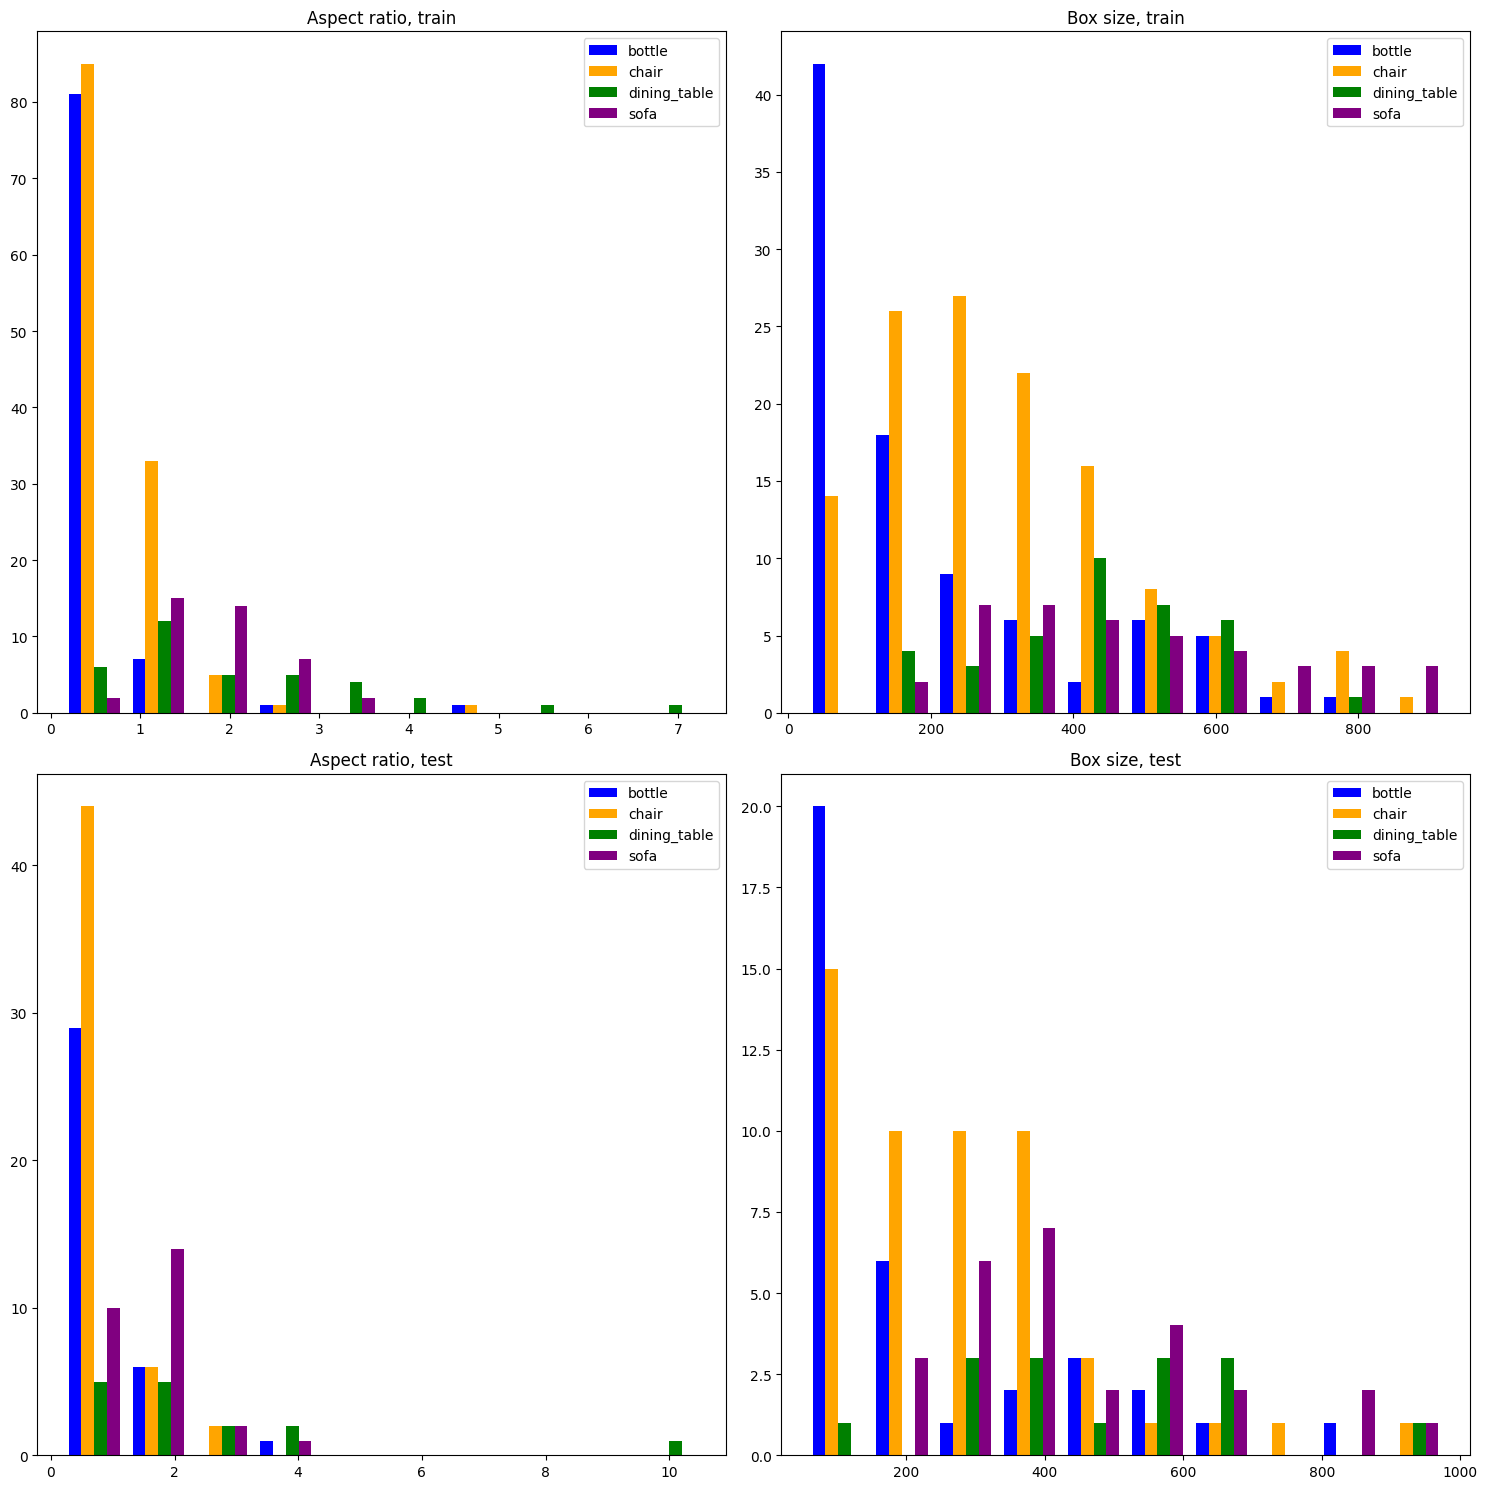

In [24]:
# Include your code here
import matplotlib.pyplot as plt
from external import get_gt_anchors
# define training and test data loaders
data_loader_0 = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test_0 = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# TRAIN
ar, labels, size_anchors=get_gt_anchors(data_loader_0)
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax0, ax1, ax2, ax3 = axes.flatten()
ax0.hist([ar[np.where(labels==1)[0]],ar[np.where(labels==2)[0]],ar[np.where(labels==3)[0]],ar[np.where(labels==4)[0]]],color=['blue','orange','green','purple'],label=class_names[1:])
ax0.legend(prop={'size': 10})
ax0.set_title('Aspect ratio, train')
ax1.hist([size_anchors[np.where(labels==1)[0]],size_anchors[np.where(labels==2)[0]],size_anchors[np.where(labels==3)[0]],size_anchors[np.where(labels==4)[0]]],color=['blue','orange','green','purple'],label=class_names[1:])
ax1.legend(prop={'size': 10})
ax1.set_title('Box size, train')

# TEST
ar, labels, size_anchors=get_gt_anchors(data_loader_test_0)
ax2.hist([ar[np.where(labels==1)[0]],ar[np.where(labels==2)[0]],ar[np.where(labels==3)[0]],ar[np.where(labels==4)[0]]],color=['blue','orange','green','purple'],label=class_names[1:])
ax2.legend(prop={'size': 10})
ax2.set_title('Aspect ratio, test')
ax3.hist([size_anchors[np.where(labels==1)[0]],size_anchors[np.where(labels==2)[0]],size_anchors[np.where(labels==3)[0]],size_anchors[np.where(labels==4)[0]]],color=['blue','orange','green','purple'],label=class_names[1:])
ax3.legend(prop={'size': 10})
ax3.set_title('Box size, test')
fig.tight_layout()
plt.show()

A continuación se van a analizar los _anchors_ que proporciona la red para cada objeto, para ver si la distribución corresponde a las descritas anteriormente.

Evaluating...
Evaluation complete in 0m 22s
Objectness-RPN. F1: 0.696913.     Precision: 0.671533. Recall: 0.724288
Global classification: F1: 0.932987.     Precision: 0.947917. Recall: 0.918521


Text(0.5, 1.0, 'Anchor size, train')

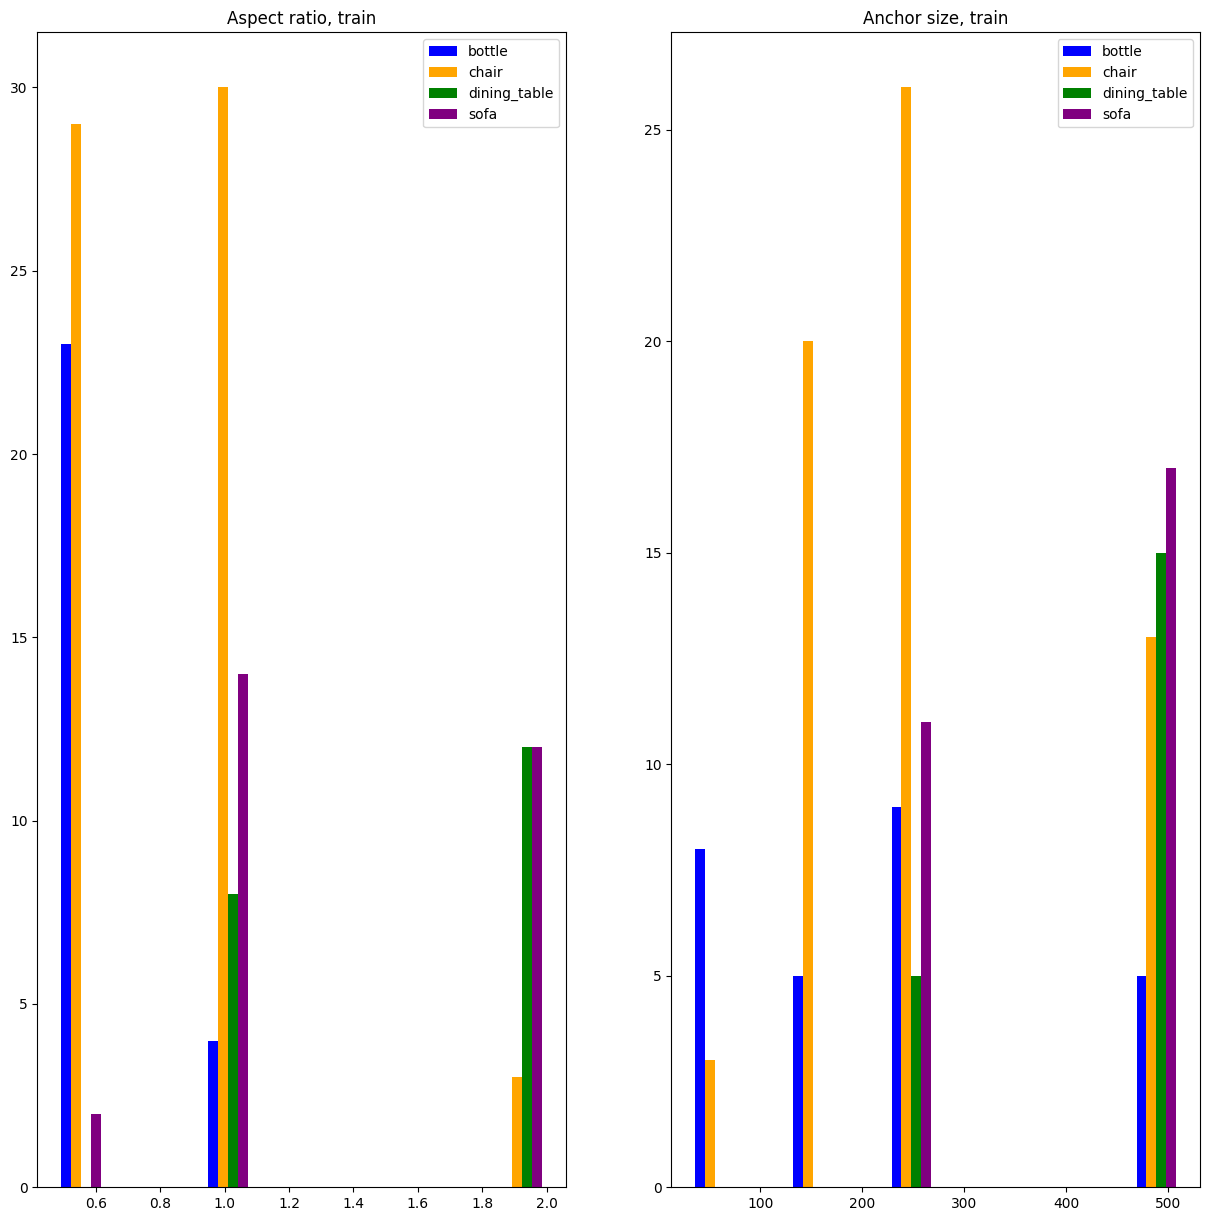

In [25]:
# Inference: extract the selected anchors
model_weights = torch.load(os.path.join(result_dir,'best_model.pth'.format(num_epochs-1)))['state_dict']
model_ft.load_state_dict(model_weights)
[_,_,_,_,_,_,anchors,l_t]=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, False, False, False)

# Anchor statistics
ar=[]
labels=[]
size_anchors=[]
for i in range(anchors.shape[0]):
    labels.append(l_t[i])
    size_anchors.append(np.sqrt((anchors[i,2]-anchors[i,0])*(anchors[i,3]-anchors[i,1])))
    ar.append((anchors[i,2]-anchors[i,0])/(anchors[i,3]-anchors[i,1]))

ar=np.array(ar)
labels=np.array(labels)
size_anchors=np.array(size_anchors)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax0, ax1 = axes.flatten()
ax0.hist([ar[np.where(labels==1)[0]],ar[np.where(labels==2)[0]],ar[np.where(labels==3)[0]],ar[np.where(labels==4)[0]]],color=['blue','orange','green','purple'],label=class_names[1:])
ax0.legend(prop={'size': 10})
ax0.set_title('Aspect ratio, train')
ax1.hist([size_anchors[np.where(labels==1)[0]],size_anchors[np.where(labels==2)[0]],size_anchors[np.where(labels==3)[0]],size_anchors[np.where(labels==4)[0]]],color=['blue','orange','green','purple'],label=class_names[1:])
ax1.legend(prop={'size': 10})
ax1.set_title('Anchor size, train')

- ¿La distribución de los _anchors_ se corresponde con la distribución de las *bounding boxes* en entrenamiento y test?

La distribución de los anchors es bastante similar a la de las bounding boxes con la verdad objetiva; se puede observar que para menores relaciones de aspecto, se predicen más botellas y sillas, que como se puede observar en los datos de las bounding boxes, suelen encontrarse en ese área. Y para mayores relaciones de aspecto, se predicen más mesas y sofás, lo que tiene sentido (ya que suelen tener una relación de aspecto "alargada" de manera horizontal); un detalle a tener en cuenta es que, debido a la natualeza de los anchors (que sólo pueden ser 1:1, 1:2 o 2:1), en las predicciones no se sobrepasa el valor 2; ya que no existen anchors con mayor relación de aspecto. Si observamos los datos, podemos ver que hay algunos objetos con bounding boxes por encima del ratio 2:1 que nos permiten los anchors actuales; por lo que existe la opción de añadir un anchor de aspecto 3:1 o incluso 4:1, para contemplar esos datos "outliers".

El ratio opuesto (es decir 1:3 o 1:4) no tiene mucho sentido, ya que todos los objetos parecen entran dentro del ratio correctamente; si pensamos en los objetos tratados, una botella, o una silla, que son los que principalmente tienen bounding boxes verticales, no suelen superar ese ratio de 1:2, y los casos en los que ocurre, no es demasiado exagerado.

- A la vista de los resultados, ¿por qué cree que la librería cambia el tamaño de las imágenes a la entrada de la red?

#### Tenga en cuenta que la regresión se mueve en el hueco entre dos escalas consecutivas (doble de tamaño). 

- Analice las salidas visuales de la red, los _anchors_ y la regresión. ¿Es la regresión buena en todos los casos? ¿En qué tipo de objetos es más útil, más grandes o más pequeños? ¿Por qué?


In [ ]:
# Para el Anchor generator
anchor_sizes = ((32,), (64,), (128,), (256,), (512,),) #(32,),
aspect_ratios = ((0.5, 1.0, 2.0, 3.0),) * len(anchor_sizes)


# Habrá que importar el AnchorGenerator
# Algo así: from torchvision_05.models.detection.rpn.py import AnchorGenerator
generador_de_achors = AnchorGenerator(
    anchor_sizes, aspect_ratios
)

# Y al llamar a la red, será:
torchvision_05.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, rpn_anchor_generator=generador_de_achors)

: 

### 3. _RoI pooling_ y clasificación.

En este apartado, se va a obtener una representación visual de las salidas del *RoI pooling* para las distintas clases (a partir de la función externa `visualize_roipooling`), y se van a analizar los resultados de clasificación.

En la siguiente celda de código se extraen representaciones visuales del *RoI pooling* para cada objeto detectado en la carpeta`roipool`, dentro de la carpeta de resultados. El *RoI pooling* proporciona como salida un mapa de características $F_r$ de tamaño $HxWxC=7x7x2048$. Cada representación, por su parte, corresponde a una celda de 7x7 en la que se representan el valor máximo de este mapa $F_r$ sobre todos los canales (es decir, cada elemento contiene el valor máximo de todos los canales para cada celda). De este modo se puede inferir la distribución espacial de las activaciones en el *RoI pooling*.  Ejecute la siguiente celda y analice las representaciones de salida.

__**IMPORTANTE__: no se utiliza la media para extraer las representaciones (*a priori* puede parecer mejor) ya que en las redes convolucionales la mayoría de los valores de los canales en cierta posición suelen ser muy bajos, y esto hace que los valores medios sean muy similares.

__**IMPORTANTE:__ la función `visualize_roipooling` hace uso de los *hook* de Pytorch, que se utilizarán en el siguiente apartado. Los *hook* de Pytorch son una serie de funciones que permiten modificar los datos de entrada o salida de alguna capa de la red durante la ejecución de la red. Esto permite tener acceso a datos intermedios de la red en tiempo de ejecución, así como realizar un *debug* controlado de la red neuronal. En concreto se usa un *register_forward_hook()*, se ejecuta tras el método *forward* de cualquier capa de la red y tiene acceso a sus entradas y salidas. 

Evaluating...
Evaluating...
Evaluation complete in 0m 27s
Objectness-RPN. F1: 0.696913.     Precision: 0.671533. Recall: 0.724288
Class: bottle. Recall: 23/36
Class: chair. Recall: 35/52
Class: dining_table. Recall: 11/15
Class: sofa. Recall: 23/27

Global classification: F1: 0.932987.     Precision: 0.947917. Recall: 0.918521
Class: bottle. F1: 1.000000.     Precision: 1.000000. Recall: 1.000000
Class: chair. F1: 0.929577.     Precision: 0.916667. Recall: 0.942857
Class: dining_table. F1: 0.900000.     Precision: 1.000000. Recall: 0.818182
Class: sofa. F1: 0.893617.     Precision: 0.875000. Recall: 0.913043


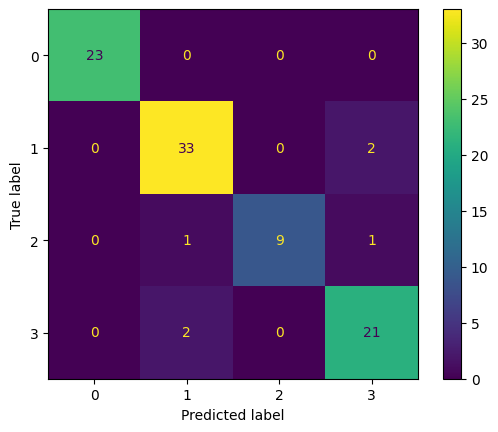

In [26]:
from external import visualize_roipooling

# For the roi-pooling experiment, analyze the top bounding-boxes (th_score>0.7) and only those with 
# th_iou>0.7 with the ground-truth
visualize_roipooling(model_ft, data_loader_test, device, class_names, 0.7, 0.7, result_dir, True)
# For the confusion matrix, experiment with the standard thresholds
[precision,recall,ap_score,cm,_,_,_,_]=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, True, False, True)
dconf=ConfusionMatrixDisplay(cm)
#dconf=ConfusionMatrixDisplay(cm,display_labels=class_names[1:])
dconf.plot()


- Céntrese en el caso de los objetos que aparecen al completo. ¿Se puede inferir la clase del objeto de la distribución espacial del *RoI pooling*, independientemente de su escala? Muestre algún ejemplo. Justifique la utilidad del *RoI pooling*. 

- Analice la matriz de confusión. ¿Qué clases es más sencillo confundir entre sí? ¿Por qué?


### 4. Funciones de pérdida.

Analice qué ocurre cuando se actúa sobre las funciones de pérdida en la red. Para ello, realice los siguientes experimentos:

- Elimine la regresión de *bounding boxes* de la red. Para ello se ponen las salidas de la regresión a 0 (vea cómo se realiza esto a partir de los *hooks*) y se anulan las losses de regresión (con el parámetro `weights`). Esto es más sencillo que modificar la arquitectura de red y el código para eliminar dichas capas. Analice las salidas visuales y los resultados.

In [27]:
def zero_features_hook(self, input, output):
    output=torch.zeros_like(output)
    return output

def zero_features_tuple_hook(self, input, output):
    output=(output[0],torch.zeros_like(output[1]))
    return output

def get_model_detection_no_bbox_regression(num_classes):
    # load a Faster RCNN model pre-trained on COCO
    model = torchvision_05.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    # Regression outputs to 0
    model.rpn.head.bbox_pred.register_forward_hook(zero_features_hook)
    model.roi_heads.box_predictor.register_forward_hook(zero_features_tuple_hook)

    return model

model_ft = get_model_detection_no_bbox_regression(num_classes)
# Send the model to GPU
model_ft = model_ft.to(device)

# We create the no_regression folder
result_dir='no_regression'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

# Weights for L_objectness, L_reg, L_cls y L_reg2 
weights=[1,0,1,0]

# Training
# construct an optimizer
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr,
                                momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=step_size,
                                                gamma=0.1)

# CSV file for training results
if os.path.exists(os.path.join(result_dir,'log.csv')):
    os.remove(os.path.join(result_dir,'log.csv'))
csv_file=open(os.path.join(os.path.join(result_dir,'log.csv')),'w')
coord_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
coord_writer.writerow(['Train total','Train rpn_box_reg','Train objectness','Train box_reg','Train classifier',
                        'Val total','Val rpn_box_reg','Val objectness','Val box_reg','Val classifier'])
best_f1=0
for epoch in range(num_epochs):
    if not os.path.exists(os.path.join(result_dir,'faster-rcnn-epoch{}.pth'.format(epoch))):
        #     train for one epoch, printing every epoch
        train_aux_losses=train_one_epoch(model_ft, optimizer, data_loader, device, weights, epoch, print_freq=250)
        # Update the learning rate
        lr_scheduler.step()
        # Validation
        val_aux_losses=eval_one_epoch(model_ft, data_loader_test, device, epoch, print_freq=250)
        # Update measurement file
        coord_writer.writerow([str(train_aux_losses['total']),str(train_aux_losses['rpn_box_reg']),str(train_aux_losses['objectness']),
                                str(train_aux_losses['box_reg']),str(train_aux_losses['classifier']),
                                str(val_aux_losses['total']),str(val_aux_losses['rpn_box_reg']),str(val_aux_losses['objectness']),
                                str(val_aux_losses['box_reg']),str(val_aux_losses['classifier'])])
        # Evaluation
        [precision,recall,f1_score,cm,total,partial,_,_]=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, False, False, False)
        # Save the state and the model with best AP-score for inference
        state = {'epoch': epoch + 1, 'state_dict': model_ft.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'scheduler':lr_scheduler.state_dict(), }
        torch.save(state, os.path.join(result_dir,'faster-rcnn-epoch{}.pth'.format(epoch)))
        if (f1_score>best_f1):
            torch.save(state, os.path.join(result_dir,'best_model.pth'.format(epoch)))
            best_f1=f1_score
    else:
        # Load this epoch information to resume training
        print("=> loading checkpoint '{}'".format(epoch))
        checkpoint = torch.load(os.path.join(result_dir,'faster-rcnn-epoch{}.pth'.format(epoch)))
        lr_scheduler.load_state_dict(checkpoint['scheduler'])
        model_ft.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}'" .format(epoch))
    
csv_file.close()

=> loading checkpoint '0'
=> loaded checkpoint '0'
=> loading checkpoint '1'
=> loaded checkpoint '1'
(TRAIN) Epoch: [2]  [233/234]  eta: 0:00:09  lr: 0.001000  loss: 0.1706 (0.3722)  loss_classifier: 0.0218 (0.0508)  loss_box_reg: 0.0000 (0.0554)  loss_objectness: 0.0794 (0.2584)  loss_rpn_box_reg: 0.0035 (0.0076)  time: 0.8455  data: 0.0041  max mem: 3165
(TRAIN) Epoch: [2] Total time: 0:38:12 (9.7980 s / it)
(VAL) Epoch: [2]  [67/68]  eta: 0:00:00  loss: 0.2059 (0.3650)  loss_classifier: 0.0334 (0.0866)  loss_box_reg: 0.0365 (0.0950)  loss_objectness: 0.1068 (0.1681)  loss_rpn_box_reg: 0.0035 (0.0155)  time: 0.4954  data: 0.0048  max mem: 3165
(VAL) Epoch: [2] Total time: 0:00:33 (0.4925 s / it)
Evaluating...
Evaluation complete in 0m 22s
Objectness-RPN. F1: 0.448682.     Precision: 0.495726. Recall: 0.409793
Global classification: F1: 0.624721.     Precision: 0.643773. Recall: 0.606764
(TRAIN) Epoch: [3]  [233/234]  eta: 0:00:03  lr: 0.001000  loss: 0.0982 (0.3131)  loss_classifier

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Inference
model_weights = torch.load(os.path.join(result_dir,'best_model.pth'.format(num_epochs-1)))['state_dict']
model_ft.load_state_dict(model_weights)
_=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, True, False, True)

Evaluating...
Evaluation complete in 0m 33s
Objectness-RPN. F1: 0.360481.     Precision: 0.540541. Recall: 0.270406
Class: bottle. Recall: 6/36
Class: chair. Recall: 21/52
Class: dining_table. Recall: 1/15
Class: sofa. Recall: 12/27

Global classification: F1: 0.581862.     Precision: 0.659091. Recall: 0.520833
Class: bottle. F1: 1.000000.     Precision: 1.000000. Recall: 1.000000
Class: chair. F1: 0.777778.     Precision: 0.636364. Recall: 1.000000
Class: dining_table. F1: 0.000000.     Precision: 0.000000. Recall: 0.000000
Class: sofa. F1: 0.153846.     Precision: 1.000000. Recall: 0.083333


#### En las salidas de la red se puede ver que ahora las *bounding boxes* predichas coinciden con los *anchors* (las pequeñas imprecisiones se deben al redondeo en la conversión entre los tamaños de imagen externa, ~500 píxeles, e interna ~800 píxeles.

- Asimismo, mediante el argumento `weights` de la función `train_one_epoch` puede introducir distintos pesos a las funciones de pérdida para dar más importancia a alguna parte de la red respecto a las demás. Puede realizar algún experimento y analizar qué ocurre.

In [ ]:
# Include your code here
# Weights for L_objectness, L_reg, L_cls y L_reg2 
# weights=[1,1,1,1]

### 5. Evaluación del trabajo autónomo del alumno.

#### Criterios de evaluación

De esta práctica (si elegida) surge la segunda evaluación para la asignatura. Una vez comprendidos los fundamentos de la detección automática de objetos con redes neuronales, puede realizar los experimentos que considere oportunos. Estos experimentos pueden ir dirigidos a:

- Hacer más eficiente la selección de _anchors_.
- Analizar los resultados y proporcionar estrategias de mejora sobre la arquitectura o el procedimiento de entrenamiento.
- Aplicar estrategias de segmentación sobre este problema, o aplicar la detección a otro problema sobre el que tenga *bounding boxes*.

#### Entregables

- Presentación (Fecha indicada en la entrega del proyecto en Aula Global). Este día cada grupo de alumnos tendrá un turno de 10 minutos de preguntas (máximo 5 minutos de presentación) sobre el apartado de trabajo autónomo con ayuda de un máximo de 3 transparencias.
- Informe + Código. Los alumnos entregarán un breve informe (2 caras para la descripción, 1 cara de referencias y figuras si fuese necesaria) donde describirán los aspectos más importantes de la solución propuesta. El objetivo es que el alumno describa los análisis y extensiones que ha planteado al modelo y justifique su objetivo y utilidad de manera breve. Asimismo, se proporcionará el código utilizado para los experimentos (bien sobre este mismo Notebook, en formato `.ipynb` o bien en código Python, en formato `.py`). 

La fecha límite de entrega del fichero de código y el informe es la fecha indicada en la entrega del proyecto en Aula Global.


#### Sugerencias

A continuación se proporcionan algunas sugerencias para que el alumno trabaje de manera autónoma, a título informativo. Si lo desea, puede centrarse en implementar una o varias de ellas.

- Se puede trabajar desde el punto de vista de los _anchors_ o el tamaño de la imagen, haciéndolos más eficientes. Haga un _clustering_ de los tamaños y relaciones de aspecto de la base de datos y utilice dichos anchors.

- De manera análoga a lo anterior, efectuando un procedimiento adecuado de _data augmentation_ se pueden ampliar el número de tamaños y relaciones de aspecto de la base de datos.

- A partir de Faster-RCNN se desarrolló Mask-RCNN, una red que además de detectar los objetos propone una segmentación píxel a píxel de los mismos. Analice las contribuciones de la misma: *RoI align* y la rama de segmentación, y efectúe alguna prueba con la misma para esta tarea (existe una implementación disponible en Pytorch y el tutorial en el que está basado este: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html utiliza Mask-RCNN).
- Se puede aplicar esta estrategia de detección a otro problema sobre el que tenga *bounding boxes*. El problema puede contar con una sola clase o ser multi-clase, y se valorará la adaptación de los procedimientos descritos a las características propias de dicha base de datos.

In [ ]:
# Include your code here
